Marklin Example: Compute vacuum field in a 3D boundary (NCSX) {#doc_marklin_ncsx_ex}
==========
In this example we compute the the vacuum magnetic field with a specified flux within a complex 3D toroidal region, the LCFS of NCSX in this case. We then demonstrate tracing the resulting field as well as compute the result of heating with anisotropic thermal conduction aligne to the magnetic field.

In [1]:
import os
import sys
import time
import h5py
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Load Marklin library

To load the Marklin python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.Marklin import Marklin

## Compute vacuum field

### Initialize Marklin object
First we create a Marklin instance to use for field calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [3]:
taylor_solver = Marklin()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   Marklin_vacuum
Revision id:          e2e143e
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh
Now we load a mesh of the desired region generated using [Cubit](https://cubit.sandia.gov/) using \ref OpenFUSIONToolkit.Marklin.Marklin.setup_mesh "setup_mesh()".

In [4]:
taylor_solver.setup_mesh(mesh_file='NCSX_plasma.h5',grid_order=2)


**** Loading OFT mesh
  Mesh File = NCSX_plasma.h5

**** Generating grid level  1
  Generating domain linkage
  Generating boundary domain linkage
  Mesh statistics:
    Volume          =  2.971E+00
    Surface area    =  2.445E+01
    # of points     =   39405
    # of edges      =  251752
    # of faces      =  413201
    # of cells      =  200854
    # of boundary points =   11493
    # of boundary edges  =   34479
    # of boundary faces  =   22986
    # of boundary cells  =   22873
  Resolution statistics:
    hmin =  2.709E-02
    hrms =  5.283E-02
    hmax =  1.318E-01
  Surface grounded at vertex   16292



[    0] WARNING : Removed curvature in    5 cells due to poorly conditioned Jacobians


### Compute vacuum field
In marklin vacuum field within a multiply connected volume, like a torus, can be computed by specifying the flux thrugh a given cut plane that traverses the mesh. In the case of a topological torus, like NCSX, this cut plane should be a poloidal plane, which we specify using a center point `hcpc` and unit normal direction `hcpv`. This defines a circular cut surface, where the amplitude of `hcpv` set the radius $r = 1/|hcpv|$, that is used to slice the model.

We then use \ref OpenFUSIONToolkit.Marklin.Marklin.compute_vac "compute_vac()" to compute the vacuum field with unit flux through the specified plane.

**Note:** In general multiple slice planes are allowed for more complex geometry (see [Benedett et al. 2021](https://doi.org/10.1088/1741-4326/abd41c)).

In [5]:
nh = 1
hcpc = np.array([[1.5,0.0,0.0],])
hcpv = np.array([[0.0,0.4,0.0],])
taylor_solver.compute_vac(nh,hcpc,hcpv,order=2)


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1


**** Creating Nedelec H1(Curl) FE space
  Order  =    2
  Minlev =   -1


**** Creating Nedelec H0 FE space
  Order  =    3
  Minlev =   -1


**** Creating Nedelec H1 FE space
  Order  =    2
  Minlev =   -1

 Injector      = INJ1
 Vacuum Energy =    28.673809994133869     


## Trace magnetic field

### Get field evaluation object
To trace the magnetic field in python we need to retrieve an interpolation object to enable evaluation of the field at arbitrary points. This can be done using \ref OpenFUSIONToolkit.Marklin.Marklin.get_binterp "get_binterp()", where the flux is set by the `vac_facs` argument.

In [6]:
binterp_obj = taylor_solver.get_binterp(vac_facs=np.r_[1.0,])

### Define tracer function for ODE integration

In [7]:
def tracer_eval(y, t, interp_obj, fac):
    b = interp_obj.eval(y)
    if interp_obj.cell.value <= 0:
        return [0.0,0.0,0.0]
    else:
        return b*fac

### Perform field line tracing
Now we trace a single field line for `[1.5, 0.0, 0.0]`, where we trace forward and backward along the field line by applying a scale factor of `-1.0` in the second case.

In [8]:
t = np.linspace(0, 40, 1000)
t0 = time.perf_counter()
sol, infodict = odeint(tracer_eval, np.array([1.5,0.0,0.0]), t, args=(binterp_obj,1.0), atol=1.E-9, full_output=True)
sol2, infodict = odeint(tracer_eval, np.array([1.5,0.0,0.0]), t, args=(binterp_obj,-1.0), atol=1.E-9, full_output=True)
t1 = time.perf_counter()

### Plot resulting field lines

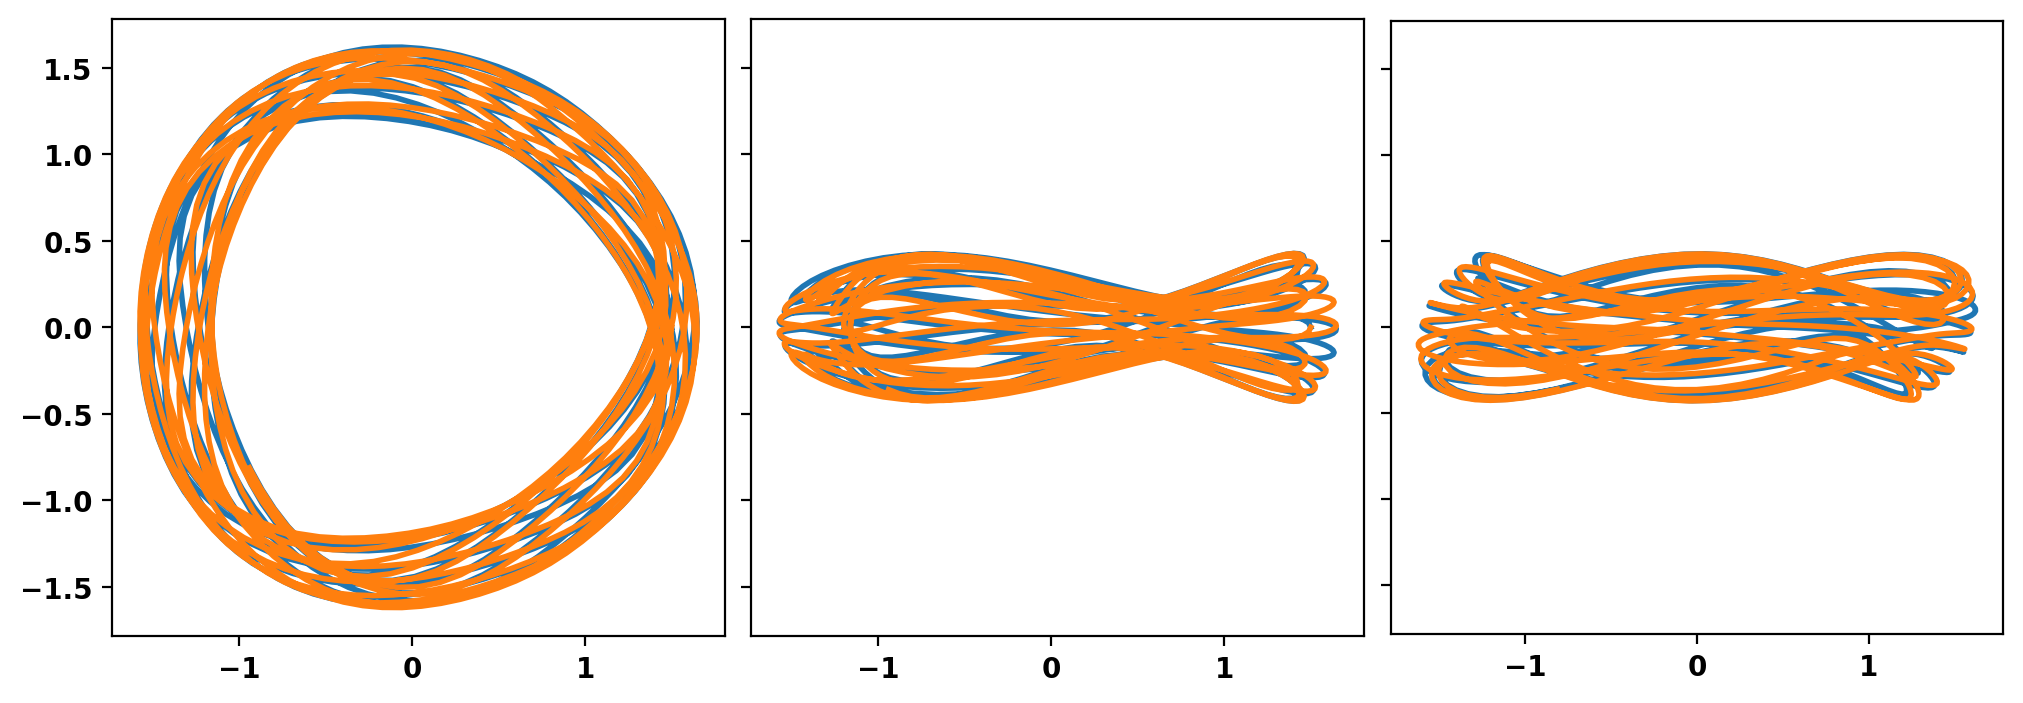

In [9]:
fig, ax = plt.subplots(1,3,sharey=True,figsize=(10,4),constrained_layout=True)
ax[0].plot(sol[:,0],sol[:,1])
ax[0].plot(sol2[:,0],sol2[:,1])
ax[0].set_aspect('equal','box')
ax[1].plot(sol[:,0],sol[:,2])
ax[1].plot(sol2[:,0],sol2[:,2])
ax[1].set_aspect('equal','box')
ax[2].plot(sol[:,1],sol[:,2])
ax[2].plot(sol2[:,1],sol2[:,2])
ax[2].set_aspect('equal','box')

### Save field for 3D plotting

In [10]:
taylor_solver.save_visit()

Starting CG solver
     0  0.000000E+00  0.000000E+00  2.512557E-02
     1 -1.284734E+01  1.074237E+03  2.478735E-03  2.307438E-06
     2 -1.432590E+01  1.666634E+03  6.035083E-04  3.621120E-07
     3 -1.433615E+01  1.673153E+03  1.056977E-04  6.317280E-08
     4 -1.433664E+01  1.673156E+03  4.883462E-05  2.918714E-08
     5 -1.433677E+01  1.673071E+03  2.687568E-05  1.606368E-08
     6 -1.433681E+01  1.672988E+03  1.421555E-05  8.497103E-09
     7 -1.433682E+01  1.672964E+03  7.678824E-06  4.589951E-09
     8 -1.433683E+01  1.672957E+03  4.424995E-06  2.645013E-09
     9 -1.433683E+01  1.672956E+03  2.523614E-06  1.508475E-09
    10 -1.433683E+01  1.672958E+03  1.329649E-06  7.947888E-10
    20 -1.433683E+01  1.672962E+03  7.379262E-09  4.410895E-12
    30 -1.433683E+01  1.672962E+03  4.875481E-11  2.914280E-14


## Solver parallel diffusion
We now compute a parallel diffusion problem to get the temperature produced in response to uniform heating with anisotropic transport that is slow in the cross-field direction compared to the parallel direction. In this case we use $\chi_{\parallel}/\chi_{\perp} = 10^5$. 

In [11]:
taylor_solver.compute_par_diff(binterp_obj,1.E-5)

Starting CG solver
     0  0.000000E+00  0.000000E+00  8.084242E-03
     1 -9.284620E-04  2.399170E-01  1.170744E-02  4.879790E-02
     2 -5.386180E-03  1.617714E+00  2.490245E-02  1.539360E-02
     3 -1.543588E-02  4.857889E+00  3.219465E-02  6.627292E-03
     4 -2.776703E-02  8.896816E+00  3.334750E-02  3.748251E-03
     5 -4.608731E-02  1.496756E+01  4.598962E-02  3.072619E-03
     6 -7.089194E-02  2.327784E+01  4.848750E-02  2.082990E-03
     7 -9.905126E-02  3.279120E+01  5.051511E-02  1.540508E-03
     8 -1.355128E-01  4.519187E+01  6.355292E-02  1.406291E-03
     9 -1.790214E-01  6.006625E+01  6.226692E-02  1.036637E-03
    10 -2.311480E-01  7.795351E+01  7.018401E-02  9.003316E-04
    20 -1.213794E+00  4.201581E+02  1.048218E-01  2.494818E-04
    30 -3.106653E+00  1.088197E+03  1.410409E-01  1.296098E-04
    40 -5.824849E+00  2.055625E+03  1.653826E-01  8.045368E-05
    50 -9.220454E+00  3.271574E+03  1.802103E-01  5.508367E-05
    60 -1.302677E+01  4.641544E+03  1.767413E-01  

## Plot temperature using pyvista
For demonstration purposes we now plot the computed temperature using [pyvista](https://pyvista.org/).

### Load data from plot files
To plot the fields we must load in the mesh from the plot files.

**Note:** In the future this will be handled by dedicated python functions, but we show it here at the moment for demonstration purposes.

In [12]:
import pyvista
with h5py.File('mesh.0001.h5','r') as h5_file:
    r = np.asarray(h5_file['R_vol'])
    lc = np.asarray(h5_file['LC_vol'])
with h5py.File('scalar_dump.0001.h5','r') as h5_file:
    T = np.asarray(h5_file['T0000'])

### Create pyvista mesh for plotting
Now we create a pyvista/VTK mesh from the loaded information and add the vector field to the mesh.

In [13]:
celltypes = np.array([pyvista.CellType.TETRA for _ in range(lc.shape[0])], dtype=np.int8)
cells = np.insert(lc, [0,], 4, axis=1)
grid = pyvista.UnstructuredGrid(cells, celltypes, r)
grid["scalars"] = T

## Plot temperature on clipped volume
Finally we plot the temperature on a clipped volume showing nested temperature contours from the wall to the core.

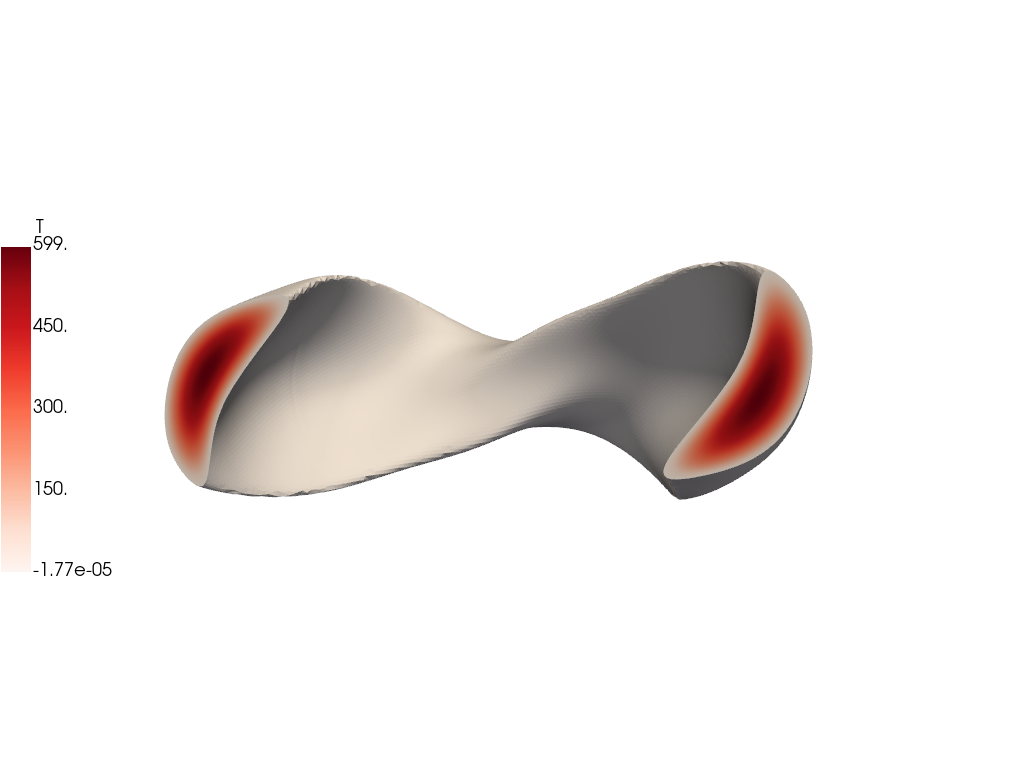

In [14]:
slice_x = grid.clip(normal='x')
p = pyvista.Plotter()
p.add_mesh(slice_x, cmap="Reds", scalar_bar_args={'title': "T", "vertical": True, "position_y":0.25, "position_x": 0.0})
p.camera.position = (7.0,2.0,0.0)
p.show(jupyter_backend='static')